# Malaria Cell Image Classification 

----------

> [By: Graham Pinsent](https://twitter.com/GrahamPinsent)  
> [Linkedin](https://www.linkedin.com/in/graham-pinsent/)  
> [GitHub](https://github.com/PerryGraham)

**Tools Used**: tensorflow-gpu, matplotlib, numpy, cv2, PIL, Sklearn. 

The purpose if this notebook is to try using a CNN model with TensorFlow to classify thin blood smears. More specifically, detecting the presence of parasites. With the use of smartphones with a small microscopic attachment, large scale blood smear tests can be done in developing countries. However, there is a limitation with the amount of expects that are able to determine the results of the tests. Computer vision can help solve this problem. Here is some code with an  explanation to implement a convolutional neural network to handle this classification. 

Data from [Malaria Cell Images Dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) uploaded by: [Arunava](https://www.kaggle.com/iarunava)

### Table of Contents:
* [Preprocessing](#Preprocessing)
* [Visualizing The Data](#Visualizing-The-Data)
* [Model Building](#Model-Building)
* [Results](#Result)

---------------

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image 
import matplotlib.image as image 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import PIL
import os

print(tf.__version__)

2.1.0


### Preprocessing 

start by reading the data from the directory with a 80:20 split for training and validation. 

In [3]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_data = image_generator.flow_from_directory("cell_images/cell_images",
                                                target_size=(163,142),
                                                class_mode="binary",
                                                batch_size=32,
                                                subset="training")

val_data = image_generator.flow_from_directory("cell_images/cell_images",
                                                target_size=(163,142),
                                                class_mode="binary",
                                                batch_size=32,
                                                subset="validation",
                                                shuffle = False)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [4]:
train_data.class_indices

{'Parasitized': 0, 'Uninfected': 1}

## Visualizing The Data

### Parasitized

Parasites are transmitted through female mosquito bites and can be seen in the blood smear image as a small purple area. There are different kinds of parasites, some of which can be lethal. These parasites can multiply in the blood and cause malaria. Early detection and treatment can be very beneficial for prevention of serious illness. 

Left is Parasitized: True
Right is Parasitized: True


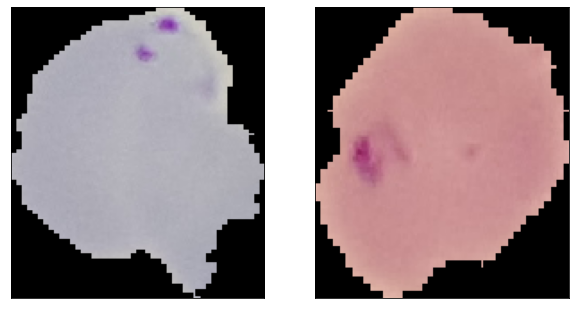

In [5]:
infect=[]
for i in range(20):
    if train_data[i][1][0]==0:
        infect.append(i)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax = plt.subplot(1,2, 1)
plt.imshow(train_data[infect[0]][0][0])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax = plt.subplot(1,2, 2)
plt.imshow(train_data[infect[1]][0][0])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
print("Left is Parasitized:",train_data[infect[0]][1][0]==0)
print("Right is Parasitized:",train_data[infect[1]][1][0]==0)

## Uninfected

Uninfected blood smears look clear and do not show dark pink areas. 

Left is Uninfected: True
Right is Uninfected: True


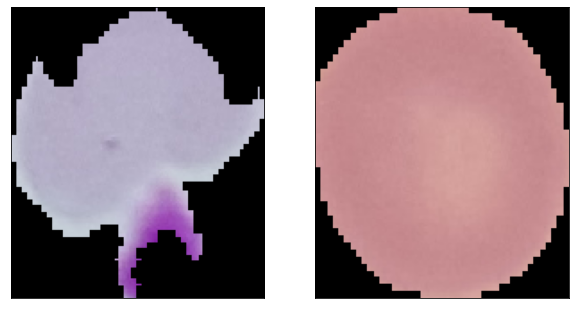

In [94]:
non=[]
for i in range(20):
    if train_data[i][1][0]==1:
        non.append(i)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax = plt.subplot(1,2, 1)
plt.imshow(train_data[non[0]][0][0])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax = plt.subplot(1,2, 2)
plt.imshow(train_data[non[1]][0][0])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
print("Left is Uninfected:",train_data[non[0]][1][0]==1)
print("Right is Uninfected:",train_data[non[1]][1][0]==1)

Checking to see how balanced the training data is between the two classes. 

In [7]:
import pandas as pd 

test = pd.DataFrame(train_data.classes, columns=["classes"])
test["c"] = 1
test = test.groupby(["classes"]).count()

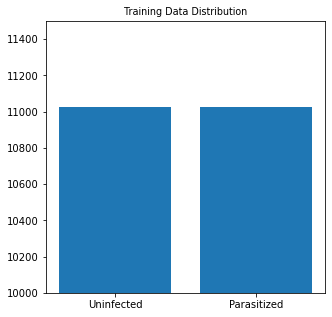

In [8]:
plt.figure(figsize=(5,5))
plt.bar(["Uninfected","Parasitized"],test.c)
plt.rcParams.update({'font.size': 8})
plt.title("Training Data Distribution")
plt.ylim((10000,11500));

Training data is ballenced between both classes

-------------

## Model Building




Used to delete logs when changing model params

In [7]:
import shutil
shutil.rmtree("./logs/") 

Function to create and compile the 7 layer network (4 conv: relu activation, & 3 maxpool) with 3 dropout layers. Using adam optimizer and sigmoid activation in the last layer because this is a binary classification. 

In [9]:
def create_model():
    model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3), activation = "relu", input_shape=(163,142,3)),
                                     tf.keras.layers.MaxPool2D((2,2)),
                                     tf.keras.layers.Conv2D(32,(3,3), activation = "relu"),
                                     tf.keras.layers.MaxPool2D((2,2)),
                                     tf.keras.layers.Dropout(0.25),
                                     tf.keras.layers.Conv2D(64,(3,3), activation = "relu"),
                                     tf.keras.layers.MaxPool2D((2,2)),
                                     tf.keras.layers.Dropout(0.25),
                                     tf.keras.layers.Conv2D(128,(3,3), activation = "relu"),
                                     tf.keras.layers.Dropout(0.25),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(256, activation = "relu"),
                                     tf.keras.layers.Dense(128, activation = "relu"),
                                     tf.keras.layers.Dense(1, activation = "sigmoid")
                                     ])
    model.compile(loss="binary_crossentropy",
            optimizer ="adam",
            metrics =['accuracy'])
    return model

Calling the model creation function and printing summary

In [10]:
model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 161, 140, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 70, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 68, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 34, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 39, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 16, 64)        0

In [24]:
# When changing something in the logs cell you need to reload the
# the tensorboard extenstion

%reload_ext tensorboard

Setting up the callbacks, one for saving weights and one for the tensorboard analysis. 

In [12]:
%load_ext tensorboard
import datetime

#Saving weights callback
cp_path = "training_1/cp.ckpt"
cp_dir = os.path.dirname(cp_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=cp_path,
                                                save_weights_only=True,
                                                verbose=1)

#Tensorboard callback 
log_path = os.path.join('logs','fit')
os.makedirs(log_path,exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,profile_batch = 100000000)

Training the model for 10 epochs

In [11]:
model.fit(train_data, 
          epochs=10, 
          validation_data=val_data,
          callbacks=[cp_callback, tensorboard_callback]);

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 689 steps, validate for 173 steps
Epoch 1/10
688/689 [============================>.] - ETA: 0s - loss: 0.4268 - accuracy: 0.7757
Epoch 00001: saving model to training_1/cp.ckpt
689/689 [==============================] - 52s 75ms/step - loss: 0.4264 - accuracy: 0.7759 - val_loss: 0.1846 - val_accuracy: 0.9421
Epoch 2/10
688/689 [============================>.] - ETA: 0s - loss: 0.1498 - accuracy: 0.9559
Epoch 00002: saving model to training_1/cp.ckpt
689/689 [==============================] - 29s 42ms/step - loss: 0.1497 - accuracy: 0.9559 - val_loss: 0.1522 - val_accuracy: 0.9454
Epoch 3/10
687/689 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9593
Epoch 00003: saving model to training_1/cp.ckpt
689/689 [==============================] - 29s 41ms/step - loss: 0.1315 - accuracy: 0.9592 - val_loss: 0.1558 - val_accuracy: 0.9474
Epoch 4/10
688/689 [============================>.] - ETA: 0s - loss: 0.125

Loading most recent model: 

In [14]:
latest = tf.train.latest_checkpoint(cp_dir)

model.load_weights(latest)

Checking the accuracy of the loaded model:

In [16]:
loss, acc = model.evaluate(val_data, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

  ...
    to  
  ['...']
173/173 - 16s - loss: 0.2205 - accuracy: 0.9475
Restored model, accuracy: 94.75%


# Results 

-----------

Used TensorBoard to evaluate the performance of my training

In [93]:
%tensorboard --logdir logs/fit/ --host localhost

Reusing TensorBoard on port 6006 (pid 9560), started 1:10:35 ago. (Use '!kill 9560' to kill it.)

Setting up the data for the confusion matrix

In [19]:
%matplotlib inline
from sklearn.metrics import confusion_matrix 
import itertools 

pred = model.predict_classes(val_data, batch_size=None)

true = val_data.classes

cm = confusion_matrix(y_true=true, y_pred=pred)

Function to plot the confusion matrix taken from the sklearn website

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

Calling the plot function in the confusion matrix data

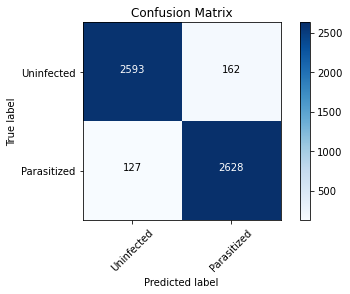

In [21]:
cm_plot_labels= ["Uninfected","Parasitized"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix");

Seems to have slightly more false negatives compared to false positives with this validation set. 

Getting the batch number and index within the batch of each false positive and false negative from the model predictions so they can be plotted: 

In [77]:
false_n = []
false_p =[]
for i in range(len(pred)):
    if pred[i] == 0 and true[i] == 1:
        false_p.append(i)
    if pred[i] == 1 and true[i] == 0:
        false_n.append(i)

batch_false_n = []
for i in false_n:
    batch_false_n.append(int(i / 32))

batch_false_p = []
for i in false_p:
    batch_false_p.append(int(i / 32))

ind_in_batch_false_n = []
for i, val in enumerate(false_n):
    ind_in_batch_false_n.append(false_n[i] - (batch_false_n[i] * 32))

ind_in_batch_false_p = []
for i, val in enumerate(false_p):
    ind_in_batch_false_p.append(false_p[i] - (batch_false_p[i] * 32))

### False Negatives

This is when the model classified a parasitized labeled image as uninfected. Here we can see a few example of parasitized labeled images that the model predicted to be uninfected:

Amount of False Negatives: 162
Top Left is Labeled as Parasitized: True
Top Right is Labeled as Parasitized: True
Bottom Left is Labeled as Parasitized: True
Bottom Right is Labeled as Parasitized: True


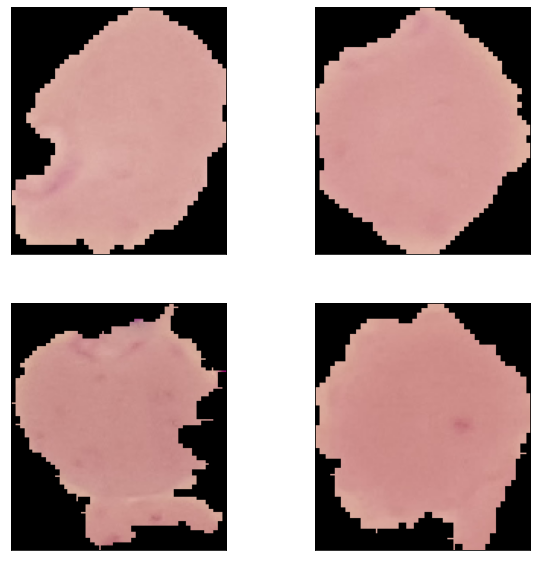

In [95]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2, figsize=(10,10))
ax = plt.subplot(2,2,1)

ax = plt.imshow(val_data[batch_false_n[0]][0][ind_in_batch_false_n[0]])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)

ax = plt.subplot (2,2,2)
ax = plt.imshow(val_data[batch_false_n[1]][0][ind_in_batch_false_n[1]])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)

ax = plt.subplot (2,2,3)
ax = plt.imshow(val_data[batch_false_n[2]][0][ind_in_batch_false_n[2]])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)

ax = plt.subplot (2,2,4)
ax = plt.imshow(val_data[batch_false_n[3]][0][ind_in_batch_false_n[3]])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)

print("Amount of False Negatives: {}".format(len(false_n)))
print("Top Left is Labeled as Parasitized:",val_data[batch_false_n[0]][1][ind_in_batch_false_n[0]]==0)
print("Top Right is Labeled as Parasitized:",val_data[batch_false_n[1]][1][ind_in_batch_false_n[1]]==0)
print("Bottom Left is Labeled as Parasitized:",val_data[batch_false_n[2]][1][ind_in_batch_false_n[2]]==0)
print("Bottom Right is Labeled as Parasitized:",val_data[batch_false_n[3]][1][ind_in_batch_false_n[3]]==0)

I am not an expert but to me these images seem to not have any pink/purple area indicating presence of parasites, even though they are labeled as parasitized. I believe that some of these images are labeled incorrectly. 

### False Positives

This is when the model classified an uninfected labeled image as parasitized. Here we can see a few example of uninfected labeled images that the model predicted to be parasitized:

Amount of False Positives: 127
Top Left is Labeled as Uninfected: True
Top Right is Labeled as Uninfected: True
Bottom Left is Labeled as Uninfected: True
Bottom Right is Labeled as Uninfected: True


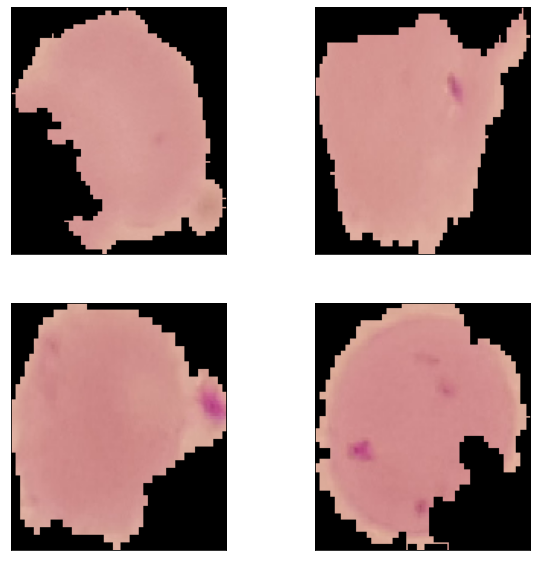

In [96]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2, figsize=(10,10))

ax = plt.subplot(2,2,1)
ax = plt.imshow(val_data[batch_false_p[0]][0][ind_in_batch_false_p[0]])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)

ax = plt.subplot (2,2,2)
ax = plt.imshow(val_data[batch_false_p[1]][0][ind_in_batch_false_p[1]])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)

ax = plt.subplot (2,2,3)
ax = plt.imshow(val_data[batch_false_p[2]][0][ind_in_batch_false_p[2]])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)

ax = plt.subplot (2,2,4)
ax = plt.imshow(val_data[batch_false_p[3]][0][ind_in_batch_false_p[3]])
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)

print("Amount of False Positives: {}".format(len(false_p)))
print("Top Left is Labeled as Uninfected:",val_data[batch_false_p[0]][1][ind_in_batch_false_p[0]]==1)
print("Top Right is Labeled as Uninfected:",val_data[batch_false_p[1]][1][ind_in_batch_false_p[1]]==1)
print("Bottom Left is Labeled as Uninfected:",val_data[batch_false_p[2]][1][ind_in_batch_false_p[2]]==1)
print("Bottom Right is Labeled as Uninfected:",val_data[batch_false_p[3]][1][ind_in_batch_false_p[3]]==1)

Similar to the false negatives, there seem to be some incorrectly labeled images within the false positives. Having a model in which has higher accuracy than the current might be a bad thing considering the amount of incorrectly labeled images. 

Thank you 